# LightGBM

In [1]:
#https://www.youtube.com/watch?v=fG8H-0rb0mY
#https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import     MeanAbsolutePercentageError
from math import sqrt
from sklearn.metrics import r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [48]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [49]:
lgb.__version__

'3.3.2'

In [50]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def train_test_split(data, n_test):
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    forecast.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    else:
        errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    # a = np.reshape(test.values, (-1,))
    # b = np.reshape(forecast.values, (-1,))
    # smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    smape_ = MeanAbsolutePercentageError(symmetric=True)
    smape = smape_(test, forecast)
    r2 = r2_score(test, forecast)
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape,
                 "r2": r2
                }
    # arredondamento
    for key, item in measures.items():
        measures[key] = round(measures[key], 6)
    return measures

In [66]:
def multi_step_forecast(data, n):
    n_test = outs = n
    train, test = train_test_split(data, n_test)
    train.dropna(inplace = True)
    response_vars = data.columns[-(outs):]
    predictions = list()
    for h, response in enumerate(response_vars):
        cols = [x for x in data.columns[:data.shape[1] - outs]]
        cols.append(response)
        data_ = train[cols]
        nrows = data_.shape[0]
        data_ = data_.iloc[:nrows-h, :] 
        data_X, data_y = data_.iloc[:, :-1], data_.iloc[:, -1]
        model = lgb.LGBMRegressor(objective='regression', n_estimators=1000)
        model.fit(data_X, data_y)
        testX, testy = test.reset_index(drop=True).loc[0, :"var1(t-1)"], test.reset_index(drop=True).loc[0, response]
        pred = model.predict([testX])[0]
        #print(f"Predicting {response}\n  > expected: {testy}, predicted: {pred}")
        predictions.append(pred)
    measures = get_measures(pd.Series(predictions), test["var1(t)"])
    df_measures = pd.DataFrame([measures])
    return predictions, df_measures, test

In [93]:
d = []
n_test = outs = 15
for x in range(60, 0, -1):
    lag = x

    df_load = load_data()
    df_weather = pd.read_csv("../data/weather_daily_data.csv", parse_dates=["DATA"])
    df_weather = df_weather[df_weather.DATA.isin(df_load.index)]
    df_load = df_load[df_weather.DATA.min():df_weather.DATA.max()] 
    df_load_2 = df_load.reset_index()
    df_merged = pd.merge(df_weather, df_load_2, left_on = "DATA", right_on = "date", how = "outer")
    df_merged.drop("date", axis = 1, inplace = True)
    df_merged.dropna(how = "all", inplace = True)
    df_merged.sort_values(by = "DATA", inplace = True)
    df_merged.load_mwmed = df_merged.load_mwmed.interpolate(method="linear")
    df_load_3 = df_merged.load_mwmed
    df_load_3.index = df_merged.DATA
    df_load_3 = df_load_3["2008-01-01":] # TESTE: MAPE PASSOU DE 3,2 PARA 3,0
    values = df_load_3.values.tolist()
    data1 = series_to_supervised(values, n_in = lag, n_out=outs, dropnan=False)

    data2 = pd.DataFrame()
    df_weather.set_index("DATA", inplace=True) # TESTE: MAPE PASSOU DE 3,2 PARA 3,0
    df_weather = df_weather["2008-01-01":] # TESTE: MAPE PASSOU DE 3,2 PARA 3,0
    for col in df_weather.columns:
        if col == "DATA":
            continue
        else:
            values = df_weather[col].values.tolist()
            df_ = series_to_supervised(values, n_in = lag, dropnan=False)
            df_.drop("var1(t)", axis = 1, inplace = True) # the response variable is the load dataframe
            df_.columns = [f"{x}_{col}" for x in df_.columns]
            data2 = pd.concat([data2, df_], axis = 1)
    
    df_weather_load = pd.concat([data2, data1], axis = 1)

    print(f"Predicting with {lag} lags...")
    pred, measures, test = multi_step_forecast(df_weather_load, outs)
    new_line = {"lags": lag, "predictions": pred, "MAPE": measures["mape"][0]}
    d.append(new_line)
df_lags_est = pd.DataFrame(d)

Predicting with 60 lags...


In [ ]:
df_lags_est.sort_values(by="MAPE")

,lags,predictions,MAPE
2,3,"[11778.719275061543, 12233.276317481832, 11714...",0.026828
0,5,"[11783.288553057924, 11793.961385727529, 11547...",0.031803
1,4,"[11694.572578698111, 11450.129168844476, 11377...",0.035672
3,2,"[11574.964695053344, 10661.09764826055, 11501....",0.040166
4,1,"[10792.896816637127, 10638.549903460162, 10890...",0.109075


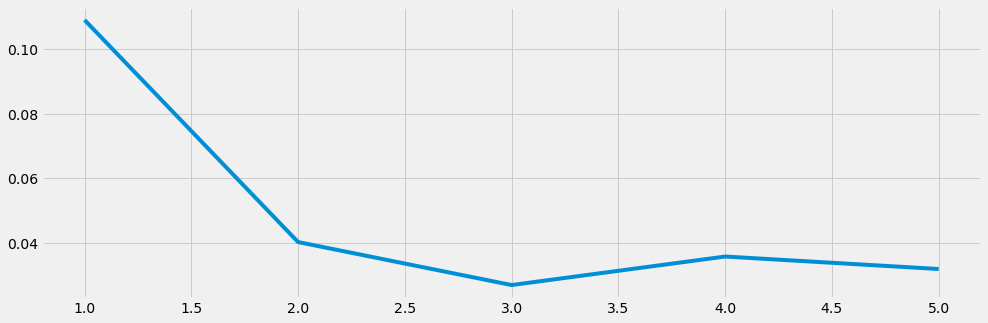

In [ ]:
plt.figure()

plt.plot(df_lags_est.lags, df_lags_est.MAPE)